# Source Code Notebook - InceptionV3


## Google Colab Configs


In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Image Conversion and Validation


### Conversion of JPG to JPEG

```
pip install opencv-python
```


In [35]:
import cv2
import os
from pathlib import Path
# DATA_DIR = "dataset/AI Art vs Real Art/" # Put unzipped files to the unzipped folder and change accordingly

# For Colab:
DATA_DIR = "/content/drive/MyDrive/dataset/AI Art vs Real Art"
def jpg_to_jpeg(data_dir):
    for dir_name in os.listdir(data_dir):
        if (dir_name != '.DS_Store'):
            files = os.path.join(data_dir,dir_name)
            for filepaths in os.listdir(files):
                file_names = os.path.join(files,filepaths)
                if file_names.endswith(".jpg") or file_names.endswith(".JPG"):
                    img = cv2.imread(str(file_names))
                    cv2.imwrite(file_names[0:-4]+".jpeg", img)
                    os.remove(file_names)

# jpg_to_jpeg(data_dir="dataset/AI Art vs Real Art/AI Art")
# jpg_to_jpeg(data_dir="dataset/AI Art vs Real Art/Real")

jpg_to_jpeg(data_dir="/content/drive/MyDrive/dataset/AI Art vs Real Art/AI Art")
jpg_to_jpeg(data_dir="/content/drive/MyDrive/dataset/AI Art vs Real Art/Real")

### Checking of the validity of Images in the dataset


In [36]:
import imghdr
IMAGE_EXTENSIONS = [".png", ".jpg", ".jpeg"]  # add there all your images file extensions
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.suffix.lower() in IMAGE_EXTENSIONS:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

## Data Preprocessing


### Import Tensorflow and Keras and check on available GPU


In [37]:
import sys
import tensorflow as tf
import keras
import platform
import numpy as np
print(f"Python Platform: {platform.version()}")
print(f"Python Version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print(f"GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: #1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024
Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Tensorflow version: 2.15.0
Keras version: 2.15.0

GPU is available


### Set constants for Images


In [38]:
BATCH_SIZE = 64
HEIGHT = 256
WIDTH = 256

## By Scratch Preprocessing


### Util Methods


In [39]:
def load_dataset(path):
    all_files = [os.path.join(path, f) for f in os.listdir(path)]
    valid_files = [f for f in all_files if f.split('.')[-1].lower() in img_type_accepted_by_tf]
    return tf.data.Dataset.from_tensor_slices(valid_files)

def split_dataset(dataset, train_size, val_size):
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    return train_dataset, val_dataset

def undersample_dataset(dataset, target_size):
    return dataset.take(target_size)

def load_and_preprocess_image(file_path):
    file_extension = tf.strings.split(file_path, '.')[-1]
    image = tf.io.read_file(file_path)

    # Decode based on the file extension
    if file_extension == 'png':
        image = tf.image.decode_png(image, channels=3)
    elif file_extension == 'bmp':
        image = tf.image.decode_bmp(image, channels=3)
    elif file_extension == 'gif':
        image = tf.image.decode_gif(image)
        image = tf.squeeze(image, axis=0)  # Extract the first frame
    else:  # Default to JPEG
        image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    return image

def label_dataset(dataset, label):
    return dataset.map(lambda x: (x, label))

### Loading and Shuffling Dataset


In [40]:
# AI_ART_PATH = 'dataset/AI Art vs Real Art/AI Art/AiArtData'
# REAL_ART_PATH = 'dataset/AI Art vs Real Art/Real/RealArt'
AI_ART_PATH = '/content/drive/MyDrive/dataset/AI Art vs Real Art/AI Art/AiArtData'
REAL_ART_PATH = '/content/drive/MyDrive/dataset/AI Art vs Real Art/Real/RealArt'
ai_images = load_dataset(AI_ART_PATH)
real_images = load_dataset(REAL_ART_PATH)

ai_dataset = ai_images.shuffle(buffer_size=1000, seed=1337)
real_dataset = real_images.shuffle(buffer_size=1000, seed=1337)

### Total Number of Samples per Label and Determining the Size


In [41]:
num_of_ai = len(os.listdir(AI_ART_PATH))
num_of_real = len(os.listdir(REAL_ART_PATH))
print(f'Total Number of Images: {num_of_ai + num_of_real} \nNumber of AI: {num_of_ai} \nNumber of Real: {num_of_real}')

ai_train_size = int(num_of_ai * 0.8) # 0.8 split
ai_val_size = num_of_ai - ai_train_size

real_train_size = int(num_of_real * 0.8)
real_val_size = num_of_real - real_train_size

Total Number of Images: 916 
Number of AI: 506 
Number of Real: 410


### Train and Validation Split


In [42]:
ai_train_dataset, ai_val_dataset = split_dataset(ai_dataset, ai_train_size, ai_val_size)
real_train_dataset, real_val_dataset = split_dataset(real_dataset, real_train_size, real_val_size)

target_train_size = min(ai_train_size, real_train_size)
target_val_size = min(ai_val_size, real_val_size)

print(f'Target Sizes of Training: {target_train_size} for Train, and {target_val_size} for Validation')

Target Sizes of Training: 328 for Train, and 82 for Validation


### Undersample


In [43]:
ai_train_dataset = undersample_dataset(ai_train_dataset, target_train_size)
real_train_dataset = undersample_dataset(real_train_dataset, target_train_size)

ai_val_dataset = undersample_dataset(ai_val_dataset, target_val_size)
real_val_dataset = undersample_dataset(real_val_dataset, target_val_size)

### Apply Preprocessing


In [44]:
ai_train_dataset= ai_train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
real_train_dataset = real_train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ai_val_dataset =ai_val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
real_val_dataset = real_val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

### Label Datasets


In [45]:
ai_train_dataset = label_dataset(ai_train_dataset, 0)
real_train_dataset = label_dataset(real_train_dataset, 1)

ai_val_dataset = label_dataset(ai_val_dataset, 0)
real_val_dataset = label_dataset(real_val_dataset, 1)

### Combine Training Datasets and Validation Datasets


In [46]:
train_dataset = ai_train_dataset.concatenate(real_train_dataset)
train_dataset = train_dataset.shuffle(buffer_size=1000)

val_dataset = ai_val_dataset.concatenate(real_val_dataset)
val_dataset = val_dataset.shuffle(buffer_size=1000)

### Batch Datasets


In [47]:
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

### Display Sample Images


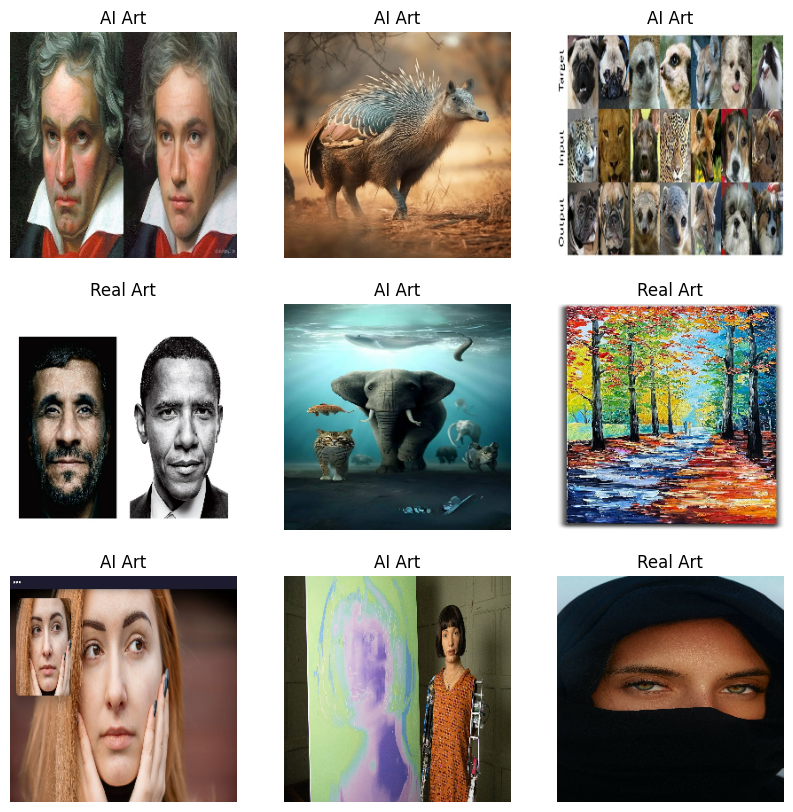

In [48]:
import matplotlib.pyplot as plt

# Function to display images from a dataset
def display_binary_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i].numpy())])
            plt.axis("off")

class_names = ['AI Art', 'Real Art']

# Display images from the balanced training dataset
display_binary_images(train_dataset, class_names)


### Prefetch Data for Optimization


In [49]:
from tensorflow import data as tf_data

train_dataset = train_dataset.prefetch(tf_data.AUTOTUNE).cache()
val_dataset = val_dataset.prefetch(tf_data.AUTOTUNE).cache()


## Importing InceptionV3 and Base Training


### Import InceptionV3 as our base model


In [50]:
base_model = keras.applications.InceptionV3(
    include_top=False, # Do not include the final layer, which classifies images
    weights="imagenet",
    pooling='max',
)

### Make base model non-trainable


In [51]:
for layer in base_model.layers:
    layer.trainable = False

## Adding New Layers to Base Model and Initial Training


### Util Methods


In [52]:
# Dynamic Learning Rate
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.1
    epochs_drop = 10
    lr = initial_lr * np.power(drop, np.floor((1 + epoch)
        / epochs_drop))
    return lr

In [53]:
stop = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_loss",
    start_from_epoch=5,
    verbose=1)

callbacks = [
    stop,
    keras.callbacks.LearningRateScheduler(lr_schedule),
]

### Creating an F1 Score Metric


In [ ]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'), axis=0)
    
    precision = tp / (tp + fp + keras.backend.epsilon())
    recall = tp / (tp + fn + keras.backend.epsilon())
    
    f1 = 2 * precision * recall / (precision + recall + keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.reduce_mean(f1)

### Creating True Positives, False Positives, True Negatives, and False Negatives metric


In [ ]:
def true_positives(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'))
    return tp

def false_positives(y_true, y_pred):
    y_pred = tf.round(y_pred)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'))
    return fp

def true_negatives(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tn = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), 'float'))
    return tn

def false_negatives(y_true, y_pred):
    y_pred = tf.round(y_pred)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'))
    return fn

### Create new Model on Top


In [54]:
from keras import layers
# Starting layers
inputs = keras.Input(shape=(HEIGHT, WIDTH, 3))
x = keras.applications.inception_v3.preprocess_input(inputs)
x = base_model(inputs, training=False) # run in inference mode

x = layers.Flatten()(x)
x = layers.Dense(2056, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

### Compile the Model


In [55]:
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary(show_trainable=True)

stop = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_loss",
    start_from_epoch=5,
    verbose=1)

callbacks = [
    stop,
    keras.callbacks.LearningRateScheduler(lr_schedule),
]

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         Y          
                                                                            
 inception_v3 (Functional)   (None, 2048)              2180278   Y          
                                                       4                    
                                                                            
 flatten_1 (Flatten)         (None, 2048)              0         Y          
                                                                            
 dense_6 (Dense)             (None, 2056)              4212744   Y          
                                                                            
 dense_7 (Dense)             (None, 1024)              2106368   Y          
                                                           

### Train the Top Layer


In [56]:
EPOCHS = 50

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics= [keras.metrics.BinaryAccuracy(threshold=0.5), 
              true_positives,
              false_positives,
              true_negatives,
              false_negatives,
              f1_score],
)
print("Fitting the top layer of the model")
model.fit(train_dataset,
          epochs=EPOCHS,
          validation_data=val_dataset,
          callbacks=callbacks,
)

Fitting the top layer of the model
Epoch 1/50
11/11 [==============================] - 21s 564ms/step - loss: 192.1999 - binary_accuracy: 0.5030 - val_loss: 6.4107 - val_binary_accuracy: 0.5031 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 2s 210ms/step - loss: 5.0799 - binary_accuracy: 0.5000 - val_loss: 1.0136 - val_binary_accuracy: 0.5031 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - 2s 230ms/step - loss: 1.1686 - binary_accuracy: 0.4848 - val_loss: 0.7070 - val_binary_accuracy: 0.5399 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - 2s 209ms/step - loss: 0.6853 - binary_accuracy: 0.5976 - val_loss: 0.7585 - val_binary_accuracy: 0.5951 - lr: 0.0010
Epoch 5/50
11/11 [==============================] - 2s 205ms/step - loss: 3.8676 - binary_accuracy: 0.5152 - val_loss: 10.3113 - val_binary_accuracy: 0.4969 - lr: 0.0010
Epoch 6/50
11/11 [==============================] - 3s 239ms/step - loss: 3.0521 - binary_accuracy: 0.5198 - val_los

## Fine Tuning the Model


### Util Methods


In [57]:
# Dynamic Learning Rate
def fine_tuned_lr_schedule(epoch):
    initial_lr = 0.00001
    drop = 0.1
    epochs_drop = 10
    lr = initial_lr * np.power(drop, np.floor((1 + epoch)
        / epochs_drop))
    return lr

In [58]:
stop = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor="val_loss",
    start_from_epoch=5,
    verbose=1)
callbacks = [
    stop,
    keras.callbacks.LearningRateScheduler(fine_tuned_lr_schedule),
]

### Unfreeze Layers


In [59]:
# for layer in base_model.layers:
#     if isinstance(layer, keras.layers.Conv2D):
#         layer.trainable = True

for layer in base_model.layers:
    layer.trainable = True

In [60]:
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.00001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics= [keras.metrics.BinaryAccuracy(threshold=0.5), 
              true_positives,
              false_positives,
              true_negatives,
              false_negatives,
              f1_score],
)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         Y          
                                                                            
 inception_v3 (Functional)   (None, 2048)              2180278   Y          
                                                       4                    
                                                                            
 flatten_1 (Flatten)         (None, 2048)              0         Y          
                                                                            
 dense_6 (Dense)             (None, 2056)              4212744   Y          
                                                                            
 dense_7 (Dense)             (None, 1024)              2106368   Y          
                                                           

In [61]:
print("Fitting the end-end model")
fine_tuned_model = model.fit(train_dataset,
          epochs=EPOCHS,
          validation_data=val_dataset,
          callbacks=callbacks,
)

Fitting the end-end model
Epoch 1/50
11/11 [==============================] - 28s 797ms/step - loss: 0.6961 - binary_accuracy: 0.6052 - val_loss: 0.6490 - val_binary_accuracy: 0.6564 - lr: 1.0000e-05
Epoch 2/50
11/11 [==============================] - 7s 594ms/step - loss: 0.6400 - binary_accuracy: 0.6753 - val_loss: 0.6562 - val_binary_accuracy: 0.6258 - lr: 1.0000e-05
Epoch 3/50
11/11 [==============================] - 7s 603ms/step - loss: 0.5913 - binary_accuracy: 0.7043 - val_loss: 0.6565 - val_binary_accuracy: 0.6564 - lr: 1.0000e-05
Epoch 4/50
11/11 [==============================] - 7s 611ms/step - loss: 0.6040 - binary_accuracy: 0.6921 - val_loss: 0.5798 - val_binary_accuracy: 0.6871 - lr: 1.0000e-05
Epoch 5/50
11/11 [==============================] - 7s 616ms/step - loss: 0.5325 - binary_accuracy: 0.7591 - val_loss: 0.6033 - val_binary_accuracy: 0.6687 - lr: 1.0000e-05
Epoch 6/50
11/11 [==============================] - 7s 656ms/step - loss: 0.4977 - binary_accuracy: 0.7652 -

## Evaluation of the Model


### Predicting a Specific Image


1/1 [==============================] - 1s 1s/step
Predictions: [0.9486346]
The predicted class for the image /content/drive/MyDrive/dataset/AI Art vs Real Art/Real/RealArt/-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpeg is: Real Art


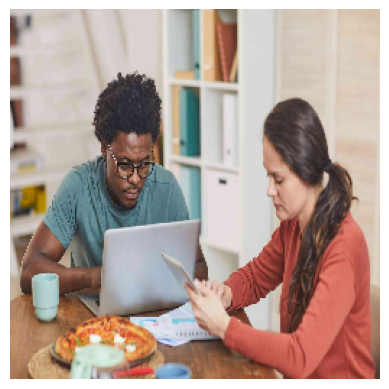

In [62]:
# img_path = "dataset/AI Art vs Real Art/Real/RealArt/-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpeg"
img_path = "/content/drive/MyDrive/dataset/AI Art vs Real Art/Real/RealArt/-man-sits-with-a-woman-on-her-phone-at-a-table-while-looking-at-a-computer_l.jpeg"

img = keras.preprocessing.image.load_img(img_path,
                                            target_size=(HEIGHT, WIDTH))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)[0]

print(f"Predictions: {predictions}")


if len(predictions.shape) == 1:
    predicted_class = 'Real Art' if predictions[0] > 0.5 else 'AI Art'
else:
    predicted_class = 'Real Art' if predictions[0][0] > 0.5 else 'AI Art'

result_string = f'The predicted class for the image {img_path} is: {predicted_class}'
print(result_string)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

### Predicting a Random Image


/content/drive/MyDrive/dataset/AI Art vs Real Art/AI Art/AiArtData
1/1 [==============================] - 0s 27ms/step
Predictions: [0.04646309]
The predicted class for the image Fantastic-Realism-Fungus-AI-Generated-Art-Psychedelic-Art-Fungus-Decor-65247356-1.png is: AI Art


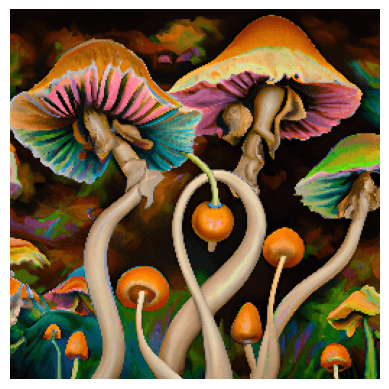

In [63]:
import os
import random
folder_number = random.randint(1, 2)  # Generate a random number between 1-3
# if folder_number == 1:
#     dataset_dir = "dataset/AI Art vs Real Art/AI Art/AiArtData"
# else:
#     dataset_dir = "dataset/AI Art vs Real Art/Real/RealArt"

if folder_number == 1:
    dataset_dir = "/content/drive/MyDrive/dataset/AI Art vs Real Art/AI Art/AiArtData"
else:
    dataset_dir = "/content/drive/MyDrive/dataset/AI Art vs Real Art/Real/RealArt"
print(dataset_dir)
file_list = os.listdir(dataset_dir)

random_file = random.choice(file_list)
image_path = os.path.join(dataset_dir, random_file)

img = tf.keras.preprocessing.image.load_img(image_path,
                                            target_size=(HEIGHT, WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)[0]

print(f"Predictions: {predictions}")


if len(predictions.shape) == 1:
    predicted_class = 'Real Art' if predictions[0] > 0.5 else 'AI Art'
else:
    predicted_class = 'Real Art' if predictions[0][0] > 0.5 else 'AI Art'

result_string = f'The predicted class for the image {random_file} is: {predicted_class}'
print(result_string)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

### Visualization in terms of Epochs


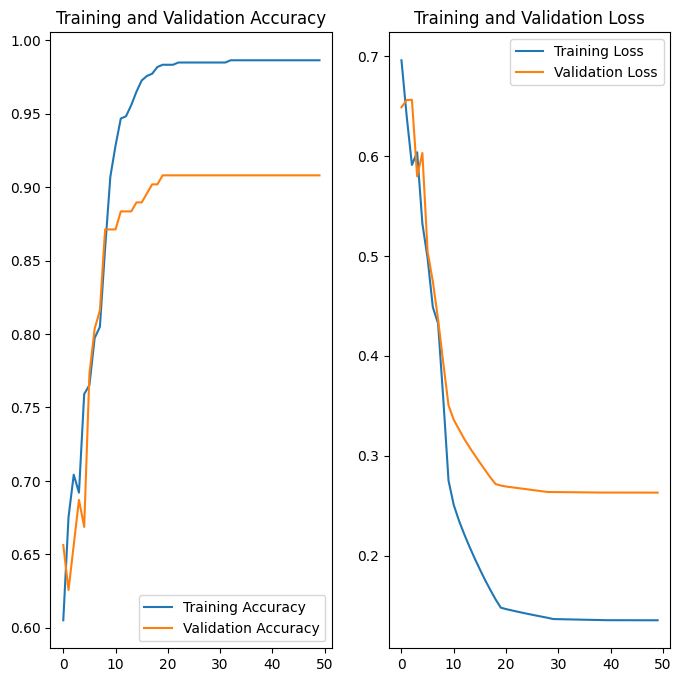

In [64]:
acc = fine_tuned_model.history['binary_accuracy']
val_acc = fine_tuned_model.history['val_binary_accuracy']

loss = fine_tuned_model.history['loss']
val_loss = fine_tuned_model.history['val_loss']
if stop.stopped_epoch != 0:
    epochs_range = range(stop.stopped_epoch+1)
else:
    epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()